# Data Science 2 Seminar
## Business/project evaluation stage

### Premise
Vacations/holidays have a visible effect on CoViD-19 infection rates in the tri-state area.

If that can be shown, I will try to form a prediction model for future holidays.

### Evaluation 
* The area of relevance is the EMR (Euregio Maas-Rhine region) as defined by the EU
  * The CoViD-19 data corresponding to that area is collected and transformed into a unified format in 




## Init

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std

import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta

from helpers import *
import init as util

from dataprep import  *

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, StratifiedKFold, GridSearchCV
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slowe


## Data preparation stage
### Generating data

...

In [2]:
# emr_df = prepareData(save=True)
# be_ref_df, nl_ref_df, de_ref_df = prepareRefCals(save=True)

### Importing previously prepared data 

In [3]:
emr_df = pd.read_csv(util.emr_infection_data)
emr_df = addDateTypeColumn(emr_df,'Date')

be_ref_df, nl_ref_df, de_ref_df = loadRefData()

In [4]:
def prepareDf(base_df, provinceId, mergeDf=None):
    loc_df = base_df.copy()
    loc_df = loc_df.loc[loc_df.Province_Id == provinceId]
    loc_df = loc_df.rename(columns={'N_Day_Rate_Change_Sliding_Window':'NDRC_SW'})
    loc_df['NDRC_SW_Yesterday'] = loc_df['NDRC_SW'].rolling(2, min_periods=1).apply(lambda x: x[0], raw=True )
    loc_df = loc_df.loc[loc_df.NDRC_SW_Yesterday.notna() & loc_df.NDRC_SW.notna() ,['NDRC_SW_Yesterday','NDRC_SW','Date']]
    if mergeDf is not None:
        loc_df = pd.merge(loc_df, mergeDf.loc[:,['Date','OffDayFactor']], on='Date', how='left')

    loc_df = loc_df.set_index('Date')
    loc_df = loc_df.asfreq('D')
    loc_df = loc_df.sort_index()

    return loc_df

In [5]:
de_off_dfs = {}
nl_off_dfs = {}
be_off_dfs = {}

for i in [10,20,30,40]:
    de_off_dfs[i] = prepareDf(emr_df, i, de_ref_df)

for i in [10,20,30,40]:
    nl_off_dfs[i] = prepareDf(emr_df, i, nl_ref_df)

for i in [10,20,30,40]:
    be_off_dfs[i] = prepareDf(emr_df, i, be_ref_df)


## Verify interval completeness

In [ ]:
for name, df_dict in [('be',be_off_dfs), ('nl',nl_off_dfs), ('de',de_off_dfs)]:
    for k, df in df_dict.items():
        print('Off days: {od} provinceId: {pid} complete: {comp}'.format(od=name, pid =k, comp=(df.index == pd.date_range(start=df.index.min(),
                                    end=df.index.max(),
                                    freq=df.index.freq)).all()))

# Ridge Regression

RR yields similar results concerning errors as Gradient Boosting did

In [ ]:
from sklearn.datasets import make_regression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split

pt_gbtr_df = de_off_dfs[30].copy()
X, y = pt_gbtr_df.loc[:,['NDRC_SW_Yesterday','OffDayFactor']], pt_gbtr_df.NDRC_SW

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

gbtReg = KernelRidge()
gbtReg.fit(X_train, y_train)
gbtReg.score(X_test, y_test) # R2

# SVM
SVM yielded significantly worse results compared to both RR and Gradient Boosting

In [ ]:
gbtr_df = de_off_dfs[30].copy()
X, y = gbtr_df.loc[:,['NDRC_SW_Yesterday','OffDayFactor']], gbtr_df.NDRC_SW

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=1)

regr = make_pipeline(StandardScaler(), SVR(kernel='rbf',C=1.0, epsilon=0.2))
regr.fit(X_train, y_train)
regr.score(X_test, y_test) # R2

# Gradient Boosting Regressor

In [6]:
pt_gbtr_df = de_off_dfs[30].copy()
X, y = pt_gbtr_df.loc[:,['NDRC_SW_Yesterday','OffDayFactor']], pt_gbtr_df.NDRC_SW

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# From Gridsearch
params = {'learning_rate': 0.075,
 'max_depth': 3,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 80,
 'subsample': 0.85
 }

gbtReg = GradientBoostingRegressor( random_state=0, **params)

gbtReg.fit(X_train, y_train)
gbtReg.score(X_test, y_test) # R2

0.7580852628307823

## Grid search
The original grid params are commented out to have it run in reasonable time.

In [ ]:
# param_grid = {
#     'max_depth': [2, 3, 5, 10],
#     'subsample': [0.05, 0.1, 0.2, 0.5, 0.8, 0.85, 0.9],
#     'n_estimators': [10, 50, 80, 90, 100, 200, 500],
#     'learning_rate': [0.01, 0.02, 0.05,0.075, 0.1, 0.5],
# 'min_samples_split': [2, 5, 10],
# 'min_samples_leaf': [2, 5, 10]
# }

param_grid = {
    'max_depth': [3],
    'subsample': [0.85],
    'n_estimators': [80, 90, 100],
    'learning_rate': [0.075],
    'min_samples_split':[2],
    'min_samples_leaf':[10]
}

gbr = GradientBoostingRegressor(criterion='mae', loss='lad', random_state=1)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator = gbr, param_grid = param_grid, 
                          cv = cv, n_jobs = -1, verbose = 0, scoring='neg_mean_absolute_error')
results = pd.DataFrame(columns={'region','offdays','score'})

for name, df_dict in [('be',be_off_dfs), ('nl',nl_off_dfs), ('de',de_off_dfs)]:
    for k, df in df_dict.items():
        X = df.loc[:,['NDRC_SW_Yesterday','OffDayFactor']]
        y = df.NDRC_SW
        grid_search.fit(X, y)
        res = grid_search.best_params_.copy()
        res['offdays'] = name
        res['region'] = k
        res['score'] = grid_search.best_score_
        results = results.append(res, ignore_index=True)

The resulting scores show that on very similar parameters the predictions across borders and across the whole EMR are roughly equally as well as the ones of off-days corresponding to their own country.
The scores as such seem to be in a range where they give predictions in the right ball park but aren't suitable for forecasts over longer stretches.
This stems from each prediction being based on a true value of the previous day.  

In [ ]:
results

# Forecaster

In [ ]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput

from joblib import dump, load

fk_df = de_off_dfs[30].copy()

test_range = 17
data_train = fk_df[:-test_range]
data_test = fk_df[-test_range:]

regr = GradientBoostingRegressor(criterion='mae',loss='lad', random_state=1, **params)
forecaster = ForecasterAutoreg( regressor = regr, lags = 100 )
# forecaster.fit(y=data_train.NDRC_SW, exog=data_train.loc[:,['NDRC_SW_Yesterday','OffDayFactor']])
forecaster.fit(y=data_train.NDRC_SW, exog=data_train.loc[:,['OffDayFactor']])

In [ ]:
# predictions = forecaster.predict(steps=test_range, exog=data_test.loc[:,['NDRC_SW_Yesterday','OffDayFactor']])
predictions = forecaster.predict(steps=test_range, exog=data_test.loc[:,['OffDayFactor']])

fig, ax = plt.subplots()
data_train.NDRC_SW.plot(ax=ax, label='train')
data_test.NDRC_SW.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

# Recursive forecasting

In [ ]:
df = de_ref_df
# df = reIndexToDate(df)
startDate = dt.strptime("2021-11-05","%Y-%m-%d")
endDate = dt.strptime("2021-11-20","%Y-%m-%d")
mask = (df.Date > startDate) & (df.Date < endDate)
df.loc[mask]
# train, test, train2 = df[:startDate], df[startDate:endDate], df[endDate:]
# train, test, train2
# train.append(train2), test

In [7]:
def recursiveWindowForecast(df, start, end, refDf=None, visualize=True, visualWindow=20):
    startDate = dt.strptime(start,"%Y-%m-%d")
    endDate = dt.strptime(end,"%Y-%m-%d")
    delta = timedelta(days=visualWindow)
    oneDay = timedelta(days=1)

    rec_fk_df = df.copy()

    train, test, train2 = rec_fk_df[:startDate-oneDay] , rec_fk_df[startDate:endDate], rec_fk_df[endDate+oneDay:]

    train= train.append(train2)

    X_train, y_train = train.loc[:,['NDRC_SW_Yesterday','OffDayFactor']], train.loc[:,'NDRC_SW']
    X_test, y_test = test.loc[:,['NDRC_SW_Yesterday','OffDayFactor']], test.loc[:,'NDRC_SW']

    gbr = GradientBoostingRegressor( random_state=0, **params)

    gbr.fit(X_train, y_train)
    # gbr.score(X_test, y_test) # R2

    predictions = test.copy()
    NDRC_yest = predictions['NDRC_SW_Yesterday'][0]
    predictions.NDRC_SW = np.NAN
    predictions.loc[:, 'NDRC_SW_Yesterday'] = np.NAN

    for idx, row in predictions.iterrows():
        row['NDRC_SW_Yesterday'] = NDRC_yest
        row['NDRC_SW'] = NDRC_yest = gbr.predict( np.array([row['NDRC_SW_Yesterday'], row['OffDayFactor']]).reshape(1, -1) )

    if visualize:
        fig, ax = plt.subplots()
        timeframe_start = startDate - delta
        timeframe_end = endDate + delta
        train[timeframe_start : timeframe_end].append(test).NDRC_SW.plot(ax=ax, label='train')
        test.NDRC_SW.plot(ax=ax, label='test')
        predictions.NDRC_SW.plot(ax=ax, label='predictions')
        if refDf is not None:
            refDfC = refDf.copy()
            mask = (refDfC.Date > startDate) & (refDfC.Date < endDate)
            addDayOffStreaks(refDfC.loc[mask], ax = ax, streakLabel='Off days')
        ax.legend();

    return predictions

,NDRC_SW_Yesterday,NDRC_SW,OffDayFactor
Date,,,
2021-10-29,1.055428,1.044687,9.0
2021-10-30,1.044687,1.034876,9.0
2021-10-31,1.034876,1.027084,9.0
2021-11-01,1.027084,1.021941,9.0
2021-11-02,1.021941,1.027323,8.0
2021-11-03,1.027323,1.025602,7.0
2021-11-04,1.025602,1.024037,6.0
2021-11-05,1.024037,1.024037,5.0


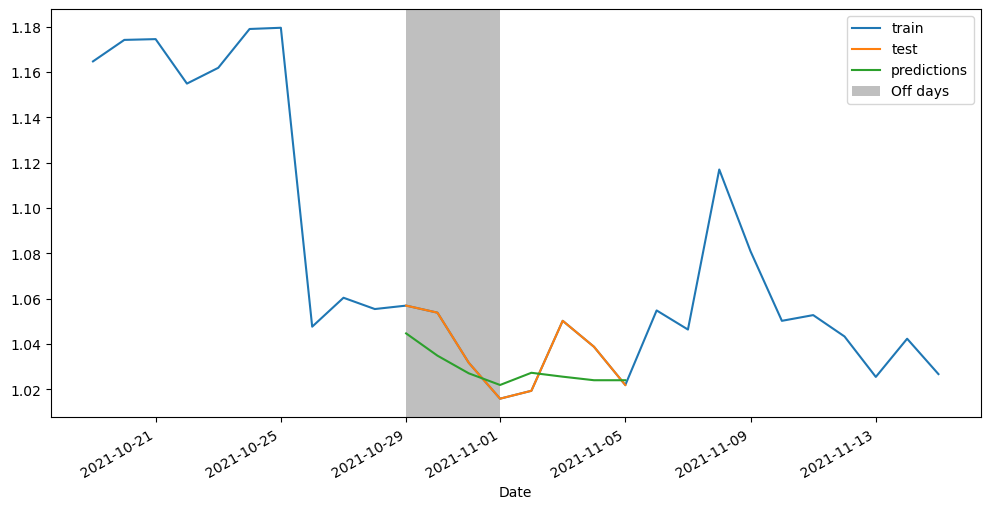

In [8]:
recursiveWindowForecast(de_off_dfs[30],'2021-10-29','2021-11-05' , refDf=de_ref_df, visualWindow=10)
